![](img/573_banner.png)

# Lecture 5: Loss functions, intro to regularization

UBC Master of Data Science program, 2022-23

Instructor: Varada Kolhatkar 

## Imports

In [1]:
import os
import sys

sys.path.append("code/.")

%matplotlib inline
import matplotlib.pyplot as plt
import mglearn
import numpy as np
import numpy.random as npr
import pandas as pd

from plotting_functions import *
from sklearn import datasets
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, RidgeCV
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

%matplotlib inline

pd.set_option("display.max_colwidth", 200)

### Learning outcomes 

From this lecture, students are expected to be able to: 

- State the three important steps in supervised machine learning.  
- Broadly explain the concept of loss functions. 
- State the loss function of linear regression. 
- Broadly explain the effect of using ordinary least squares vs. absolute value loss function. 
- Explain why ordinary least squares is not a suitable loss function for classification problems. 
- Explain the trick of using $y_iw^Tx_i$ when defining loss functions for classification problems.  
- Broadly explain the intuition behind 1/0, exponential, hinge and logistic loss. 
- Explain the difference between sigmoid and logistic loss. 
- Explain the general idea of complexity penalties.
- Relate feature selection to the idea of complexity penalty. 
- Explain the general idea of L0 and L2 regularization.

## Loss functions: big picture 

In DSCI 571, we primarily focused on how `predict` works. In this lecture, we'll talk a bit about how `fit` works, primarily in the context of linear models. 

In supervised machine learning we learn a mapping function which relates `X` to `y`. How do we learn this function? 

We can start to think of (a lot of) ML as a 3-step process:

1. Choose your **model** 
2. Choose your **loss function**
3. Choose your **optimization algorithm**

<!-- ![](img/supervised-ML-fit-process.png) -->

<img src="img/supervised-ML-fit-process.png" width="500">

### Choosing your model

- What kind of mapping function do you want to learn?
- Suppose we decide to go with a linear model. Then the possible mapping functions to choose from are only going to be linear functions. 
    - Example: $\hat{y}=5x_1+ 2x_2 - x_3$ or $\hat{y}=10x_1+2x_2$

### Choosing your loss function
- We define a criteria to quantify how bad the model's prediction is in comparison to the truth. This is called a **loss function** usually denoted as: $\mathcal{l}(y, \hat{y})$.
- Examples:
    - Binary classification: $\mathcal{l}(y, \hat{y}) = \begin{cases} 0 \text{ if } y = \hat{y} \\ 1, \text{otherwise}\end{cases}$
    - Regression: $\mathcal{l}(y, \hat{y}) = (y-\hat{y})^2$
- Quantifies unhappiness of the fit across the training data. 
- Captures what is important to learn. 
- Using our loss function and our training data, we can examine which model function is better
    - Example: Which linear function is better for the given problem: $\hat{y}=5x_1+ 2x_2 - x_3$ or $\hat{y}=10x_1+2x_2$? 

### Choosing your optimization algorithm 
- Our goal is finding the optimal parameters so that the model's predictions are  least bad compared to the truth.
- The optimization algorithm computationally finds the minimum of the loss function.
- More on this in DSCI 572. 

<br><br><br><br>

## Linear regression loss function

In the context of linear regression, when we call `fit`, a hyperplane is learned by the model. Let's look at a toy example. 

Consider this toy regression dataset with only one feature. 

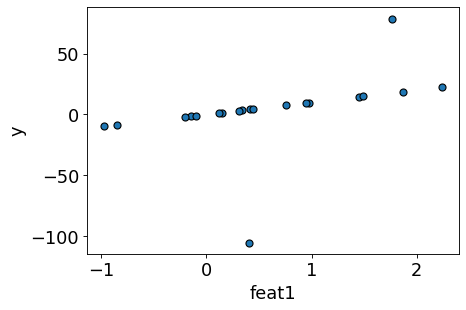

In [2]:
X_toy, y_toy = gen_outlier_data() # user-defined function in plotting_functions.py
plot_reg(X_toy, y_toy) # user-defined function in plotting_functions.py

Let's train `sklearn`'s `LinearRegression` and get the regression line. 

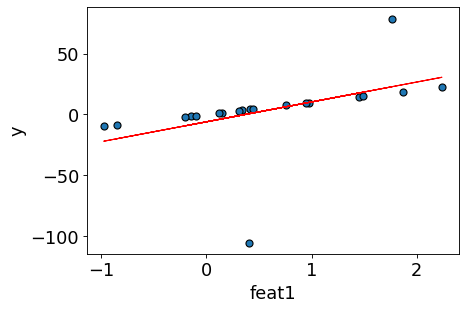

In [3]:
lr = LinearRegression()
lr.fit(X_toy, y_toy)
plot_reg(X_toy, y_toy, preds=lr.predict(X_toy), line=True)

- There could be many possible lines.
- Why did linear regression pick this particular line? 
- Is this the "best" possible line? 

### Ordinary least squares

Linear regression selected the above line by **minimizing the quadratic cost between the actual target $y$ and the model predictions $\hat{y}$**.

$$
\begin{equation}
\begin{split}
J(w) &= \sum_{i=1}^n (y_i - w^Tx_i)^2 \\
\end{split}
\end{equation}
$$
- Where, 
    - $n \rightarrow$ number of examples
    - $w \rightarrow$ weight vector (column vector)
- This is called **ordinary least squares (OLS)**, the most commonly used **loss function** or **cost function** for linear regression. 
- We define loss of a single example as squared difference between prediction and true target.
- The total loss is summation of losses over all training examples.  

_Note: In this course all vectors are assumed to be column vectors._

### Learning with OLS

Among all possible lines, it will decide the "best" line by learning parameters $w$ which make predictions for each training example as close as possible to the true $y$ according to the loss function. 

So once you decide what kind of model you are going to train, you can think of `fit` as a two-step process.

- We need two things: 
    - **Loss function**: A metric to measure how much a prediction differs from the true $y$. 
    - **Optimization algorithm**: for iteratively updating the weights so as to minimize the loss function. (You'll talk about this in detail in 572.)   

- In 1D (only one feature in X), we will be learning two parameters: $w_1$ and $w_2$ ($\beta_1, \beta_2$ in the picture below) 
- Our loss function will look like a bowl. 
- The contour plot projected on 2D looks like ellipses.
- (Optional) For a well-defined ordinary least squares, there is a unique solution and it can be calculated analytically. 
 $$w_{OLS}= (X^TX)^{-1}X^Ty$$

![](img/OLS_loss_function.png)
Source: https://www.statlearning.com/

Let's experiment with different loss functions. 

In [4]:
def lr_loss_squared(w, X, y): # define OLS loss function
    return np.sum((y - X @ w) ** 2)

Let's use an optimizer from `scipy.optimize` and get the learned parameters. 

In [5]:
from scipy.optimize import minimize # scipy optimizer 
X_1 = np.concatenate((np.ones(X_toy.shape), X_toy), axis=1) # Create a column of ones
w_min = minimize(lr_loss_squared, np.zeros(2), args=(X_1, y_toy)).x # minimize the loss function defined above using an optimizer 

In [6]:
print("scipy.optimize weights: ", w_min[1])
print("scipy.optimize intercept: ", w_min[0])

scipy.optimize weights:  16.342238893263442
scipy.optimize intercept:  -6.017153240936053


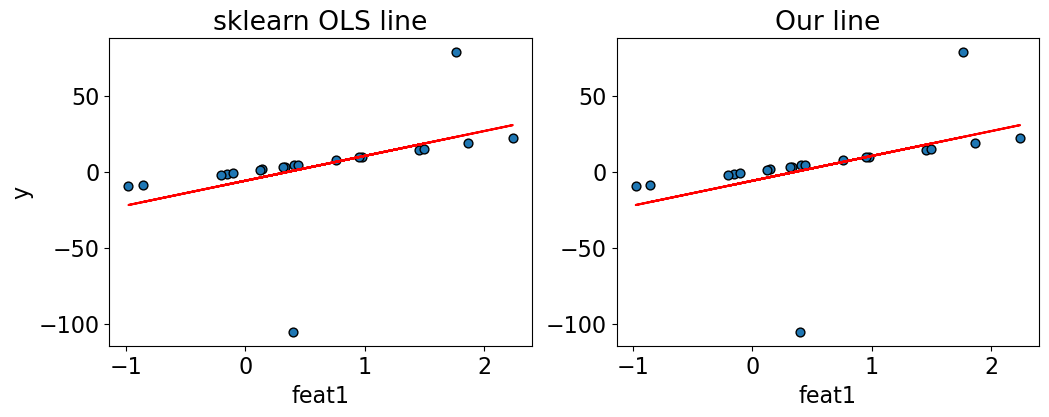

In [7]:
# user-defined function in plotting_functions.py
compare_regression_lines(X_toy, y_toy, lr.predict(X_toy), X_1@w_min) 

The sklearn OLS line and our OLS line are exactly the same!   

- Squared error loss penalizes really heavily for big errors compared to the absolute loss. 
- If you have a data point with a big error, the loss function is going to focus a lot on it as the penalty is very high for this this data point. 

### Absolute value loss

- An example of a different loss function would be the **absolute value loss** where we do not punish large errors as severely as ordinary least squares.  

$$J(w) = \sum_{i=1}^n \lvert y_i - w^Tx_i\lvert$$

- What are the implications of switching between these different choices? 
- Let's try it out. 

In [8]:
def lr_loss_abs(w, X, y):
    return np.sum(np.abs(y - X @ w))

In [9]:
w_min_abs = minimize(
    lr_loss_abs, np.zeros(2), args=(X_1, y_toy)
).x  # don't try this at home

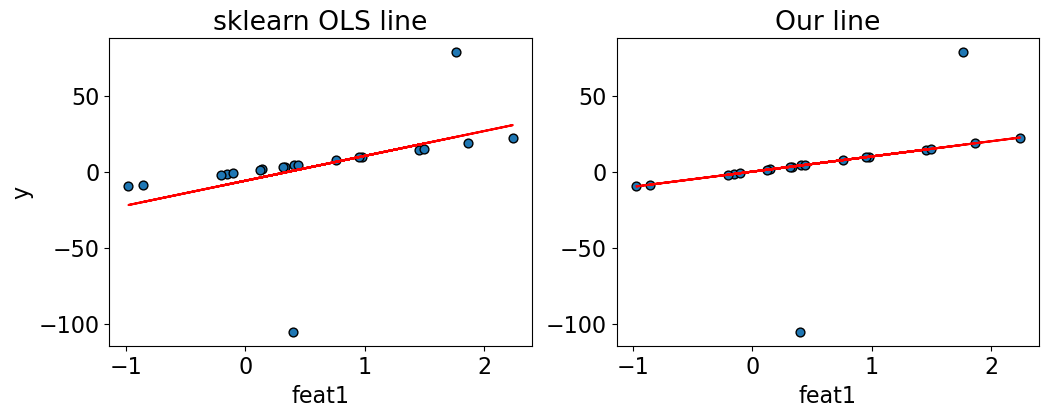

In [10]:
compare_regression_lines(X_toy, y_toy, lr.predict(X_toy), X_1@w_min_abs)

- So, it seems like we got very different fits by changing the loss function.
- In this case, the absolute loss gave us robust regression.
- **The loss function you pick is important!**

Note: You will talk about robust regression in DSCI 561/562 and you'll learn the maximum likelihood interpretation of the loss in DSCI 562. 

<br><br><br><br>

## Loss functions in classification problems

### How about using OLS for binary classification? 

- Let's assume binary classification with two classes: +1 and -1.
- So $y_i$ values are just +1 or -1. 
- The raw model output $w^Tx_i$ can be any number. 
- Does it make sense to use this loss function for binary classification?

$$f(w)=\sum_{i=1}^n (y_i - w^Tx_i)^2$$

In [11]:
from sklearn.datasets import make_classification
X_classif, y_classif = make_classification(20, n_features=2, n_informative=2, n_redundant=0, random_state=122)
y_classif[y_classif == 0] = -1

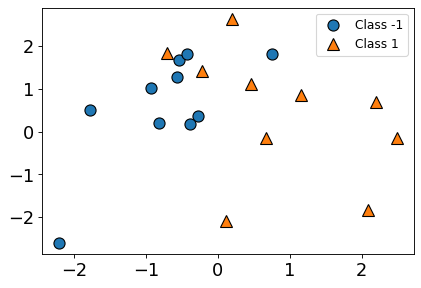

In [12]:
plt.figure(figsize=(6, 4), dpi=80)
mglearn.discrete_scatter(X_classif[:, 0], X_classif[:, 1], y_classif)
plt.legend(["Class -1", "Class 1"], loc=1, fontsize=11);

In [13]:
logreg = LogisticRegression()
logreg.fit(X_classif, y_classif)

LogisticRegression()

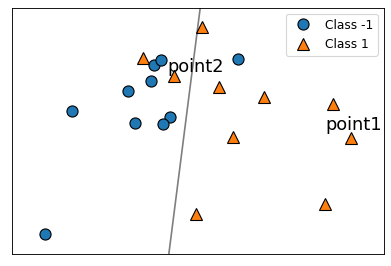

In [14]:
plt.figure(figsize=(6, 4), dpi=80)
mglearn.discrete_scatter(X_classif[:, 0], X_classif[:, 1], y_classif)
plt.legend(["Class -1", "Class 1"], loc=1, fontsize=11)
mglearn.plots.plot_2d_separator(
    logreg, X_classif, eps=0.5, alpha=0.5
)
point1 = [2.48458573, -0.15474787]
point2 = [-0.22636803,  1.41418926]
plt.annotate("point1", point1, [point1[0] - 0.4,point1[1] + 0.2]);
plt.annotate("point2", point2, [point2[0] - 0.1, point2[1] + 0.1]);

- The model seems to be correct and confident about point1. 
- The model seems to be incorrect about point2 
- Should the loss for point1 be higher or lower than point2? 
- Let's calculate least square losses for these points. 

For point1, the correct prediction $y_i$ is 1. So $(y_i - w^Tx_i)^2$ will be

In [15]:
(1 - logreg.coef_.ravel()@point1 + logreg.intercept_)**2

array([4.82807419])

For point2, the correct prediction $y_i$ is again 1. So $(y_i - w^Tx_i)^2$ will be

In [16]:
(1 - logreg.coef_.ravel()@point2 + logreg.intercept_)**2

array([2.33661675])

- Does it make sense? 
- Is this loss function capturing what we want it to capture? 

<br><br>

### What should be the loss? (Activity: 4 mins)

- Consider the following made-up classification example where target (true `y`) is binary: -1 or 1. 
- The true $y$ (`y_true`) and models raw scores ($w^Tx_i$) are given to you. 
- You want to figure out how do you want to punish the mistakes made by the current model.
- How will you punish the model in each case?  

In [17]:
data = {
    "y_true": [1, 1, 1, 1, -1, -1, -1, -1],
    "raw score ($w^Tx_i$)": [10.0, 0.51, -0.1, -10, -12.0, -1.0, 0.4, 18.0],
    "correct? (yes/no)":["yes", "yes", "no", "no", "yes", "yes", "no", "no"],
    "confident/hesitant?":["confident", "hesitant", "hesitant", "confindent", "confident", "hesistant", "hesitant", "confident"],
    "punishment":["None", "small punishment", "", "", "", "", "", ""]
}
pd.DataFrame(data)

,y_true,raw score ($w^Tx_i$),correct? (yes/no),confident/hesitant?,punishment
0,1,10.00,yes,confident,None
1,1,0.51,yes,hesitant,small punishment
2,1,-0.10,no,hesitant,
3,1,-10.00,no,confindent,
4,-1,-12.00,yes,confident,
5,-1,-1.00,yes,hesistant,
6,-1,0.40,no,hesitant,
7,-1,18.00,no,confident,


### What do we want?

- Need a loss that encourages 
    - $w^Tx_i$ to be positive when $y_i$ is $+1$ 
    - $w^Tx_i$ to be negative when $y_i$ is $-1$   

### Key idea 

- **Consider the product $y_iw^Tx_i$**. 
- We always want this quantity to be positive because
- If $y_i$ and $w^Tx_i$ have the _same sign_, the product will be positive.
    - $w^Tx_i$ is positive and $y_i$ is positive 🙂
    - $w^Tx_i$ is negative and $y_i$ is negative 🙂
- If they have _oppositve signs_, the product will be negative.
    - $w^Tx_i$ is positive and $y_i$ is negative 😔 
    - $w^Tx_i$ is negative and $y_i$ is positive 😔

- We'll see this type of plots, where we plot $y_iw^Tx_i$ vs. the loss $f_i(w)$ for point $x_i$.
- Shows loss for one example.  

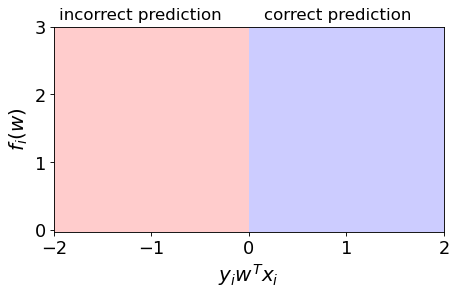

In [18]:
plot_loss_diagram();

### 0/1 loss

- Binary state of happiness.
- We are happy (loss=0) when the $y_iw^Tx_i \geq 0$ 
$$y_iw^Tx_i \geq 0, f_i(w) = 0$$
- We are unhappy (loss=1) when $y_iw^Tx_i < 0$ 
$$y_iw^Tx_i < 0, f_i(w) = 1$$

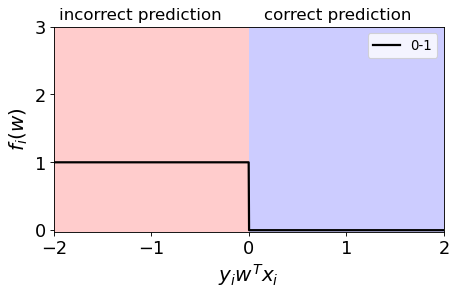

In [19]:
grid = np.linspace(-2, 2, 1000)
plot_loss_diagram()
plt.plot(grid, grid < 0, color="black", linewidth=2, label="0-1")
plt.legend(loc="best", fontsize=12);

### Preferences

- In 0/1 loss we are giving the same penalty to the examples where we are only slightly incorrect vs very incorrect. 
- It might be nice to have some preferences: <br>
    - <span style="color:green">**correct and confident**</span> (positive value with big magnitude of $y_iw^Tx_i$) <br> **>** <span style="color:cyan"> **correct and hesitant** </span>  (positive value with small magnitude of $y_iw^Tx_i$) <br> **>** <span style="color:orange">**incorrect and hesitant**</span> (negative value with small magnitude of $y_iw^Tx_i$) <br> **>**  <span style="color:red">**incorrect and confident**</span> (negative value with big magnitude of $y_iw^Tx_i$) 

### Exponential loss

- Punish the wrong predictions exponentially. 
$$\exp(-y_iw^Tx_i)$$ 

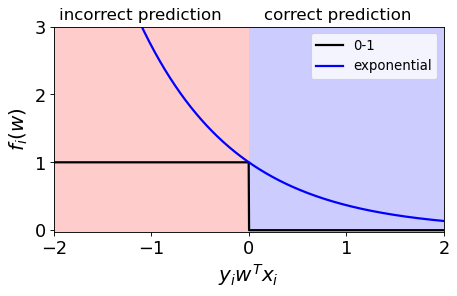

In [20]:
plot_loss_diagram()
plt.plot(grid, grid < 0, color="black", linewidth=2, label="0-1") # 0-1 loss
plt.plot(grid, np.exp(-grid), color="blue", linewidth=2, label="exponential") # exponential loss
plt.legend(loc="best", fontsize=12);

### Intuition 

- The function gets smaller as $y_iw^Tx_i$ gets larger, so it encourages correct classification. 
- So if we minimize this loss, which means if we move down and to the right, it is encouraging positive values and hence correct predictions. 

### Hinge Loss 

- Confident and correct examples are not penalized 
- Grows linearly for negative values in a linear fashion. 

$$max(0, 1 - y_iw^Tx_i)$$ 

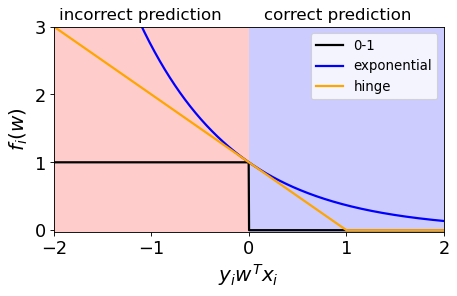

In [21]:
plot_loss_diagram()
plt.plot(grid, grid < 0, color="black", linewidth=2, label="0-1")
plt.plot(grid, np.exp(-grid), color="blue", linewidth=2, label="exponential")
plt.plot(grid, np.maximum(0, 1 - grid), color="orange", linewidth=2, label="hinge")
plt.legend(loc="best", fontsize=12);

- When you use Hinge loss with L2 regularization (coming up), it's called a linear support vector machine.  
    $$f(w) = \sum_{i=1}^n max\{0,1-y_iw^Tx_i\} + \frac{\lambda}{2} \lVert w\rVert_2^2$$
- For more mathematical details on these topics see the following slide decks from CPSC 340. 
    - [Linear classifiers](https://www.cs.ubc.ca/~schmidtm/Courses/340-F19/L20.pdf)
    - [More on linear classifiers](https://www.cs.ubc.ca/~schmidtm/Courses/340-F19/L19.pdf)
- It will make more sense when you learn about optimization in DSCI 572. 

### Logistic loss (logloss)

- Used in logistic regression
- Grows linearly for negative values which makes it less sensitive to outliers. 

  $$\log\left(1+\exp(-y_iw^Tx_i)\right)$$

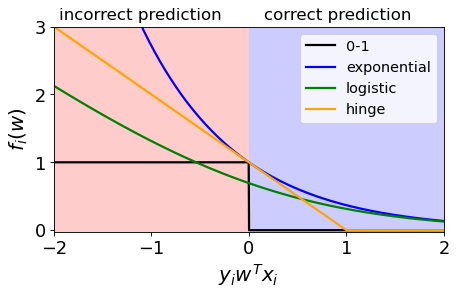

In [22]:
plot_loss_diagram()
plt.plot(grid, grid < 0, color="black", linewidth=2, label="0-1")
plt.plot(grid, np.exp(-grid), color="blue", linewidth=2, label="exponential")
plt.plot(grid, np.log(1 + np.exp(-grid)), color="green", linewidth=2, label="logistic")
plt.plot(grid, np.maximum(0, 1 - grid), color="orange", linewidth=2, label="hinge")
plt.legend(loc="best", fontsize=13);

### Sigmoid vs. logistic loss

- A common source of confusion: 
    - Sigmoid: $\frac{1}{(1+\exp(-z))}$
    - logistic loss: $\log(1+\exp(-z))$
- They look very similar and both are used in logistic regression.
- They have very different purposes. 

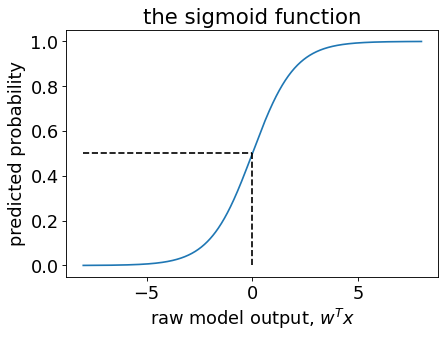

In [23]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))
raw_model_output = np.linspace(-8, 8, 1000)
plt.figure(figsize=(6, 4), dpi=80)
plt.plot(raw_model_output, sigmoid(raw_model_output))
plt.plot([0, 0], [0, 0.5], "--k")
plt.plot([-8, 0], [0.5, 0.5], "--k")
plt.xlabel("raw model output, $w^Tx$")
plt.ylabel("predicted probability")
plt.title("the sigmoid function");

### Sigmoid vs. logistic loss

- Sigmoid function: $$\frac{1}{(1+\exp(-z))}$$
    - Maps $w^Tx_i$ to a number in $[0,1]$, to be interpreted as a probability. 
    - This is important in `predict_proba`. 

- Logistic loss: $\log(1+\exp(-z))$ 
    - Maps $y_iw^Tx_i$ to a positive number, which is the loss contribution from one training example. 
    - This is important in `fit`.

### (Optional) Another source of confusion 

- You might see this alternative formulation for logistic loss. 
- For example see [here](https://developers.google.com/machine-learning/crash-course/logistic-regression/model-training) or [here](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html).


$$f(w) = \sum_{x,y \in D} -y log(\hat{y}) - (1-y)log(1-\hat{y})$$

- Although this looks very different than the loss function we saw before, they produce the same loss. 
- This is also referred to as cross-entropy loss. 
- Logistic loss = cross-entropy loss 

### (Optional) The key difference between them

- This formulation assumes the classes to be 0 and 1. 
$$f(w) = \sum_{x,y \in D} -y log(\hat{y}) - (1-y)log(1-\hat{y})$$
   
- Our previous formulation assumes classes to be -1 and +1. 
  $$f(w)=\sum_{i=1}^n\log\left(1+\exp(-y_iw^Tx_i)\right)$$    

### Which loss function should I use?

- This part is more of an art than science.
- What kind of penalty I want to put on the examples which are far away from the truth?
- Many other loss functions available out there
- ML researchers come up with their own loss functions based on their needs.

### Break (~5 mins)

![](img/eva-coffee.png)

<br><br><br><br>

## Regularization: Motivation and notation 

### Complex models and the fundamental tradeoff

- We’ve said that complex models tend to overfit more.
- Recall: polynomial degree and train vs. validation scores. 

Let's generate some synthetic data

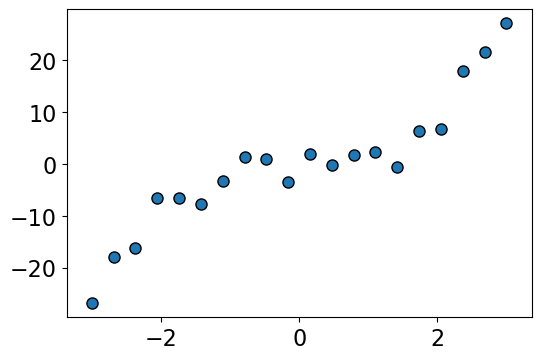

In [24]:
n = 20
np.random.seed(4)
X_train = np.linspace(-3, 3, n)
y_train = X_train**3 + npr.randn(n) * 3

n = 20
X_valid = np.linspace(-3, 3, n)
y_valid = X_valid**3 + npr.randn(n) * 3

# transforming the data to include another axis
X_train = X_train[:, np.newaxis]
y_train = y_train[:, np.newaxis]

X_valid = X_valid[:, np.newaxis]
y_valid = y_valid[:, np.newaxis]

# plt.scatter(X_train, y_train, color="blue")
plt.figure(figsize=(6, 4))
mglearn.discrete_scatter(X_train, y_train, s=8);

Let's fit polynomials of different degrees on the synthetic data. 

Column
    [0] Column
        [0] IntSlider(end=20, start=1, value=1)
    [1] Row
        [0] Str(None, name='interactive00102')

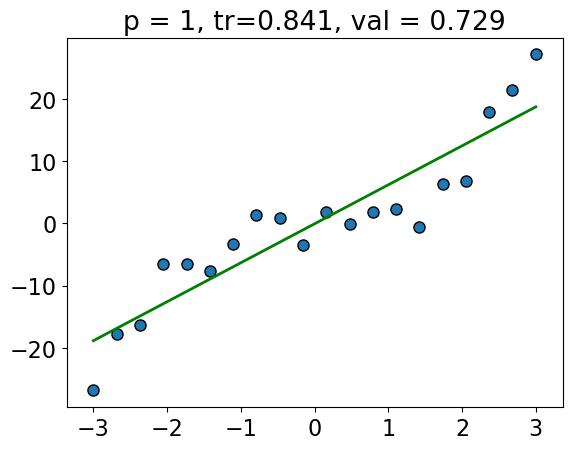

In [25]:
import panel as pn
from panel import widgets
from panel.interact import interact

pn.extension()

def f(degree=1):
    plot_poly_deg(X_train, y_train, X_valid, y_valid, degree=degree, valid=True)
    
interact(f, degree=widgets.IntSlider(start=1, end=20, step=1, value=1))

- The training score goes up as we increase the degree of the polynomial, and is highest for $p = 19$.
- The validation score first goes up and then down. 
- The validation score is highest for $p = 3$, and it goes down as we increase the degree after that; we start overfitting after $p=3$.   

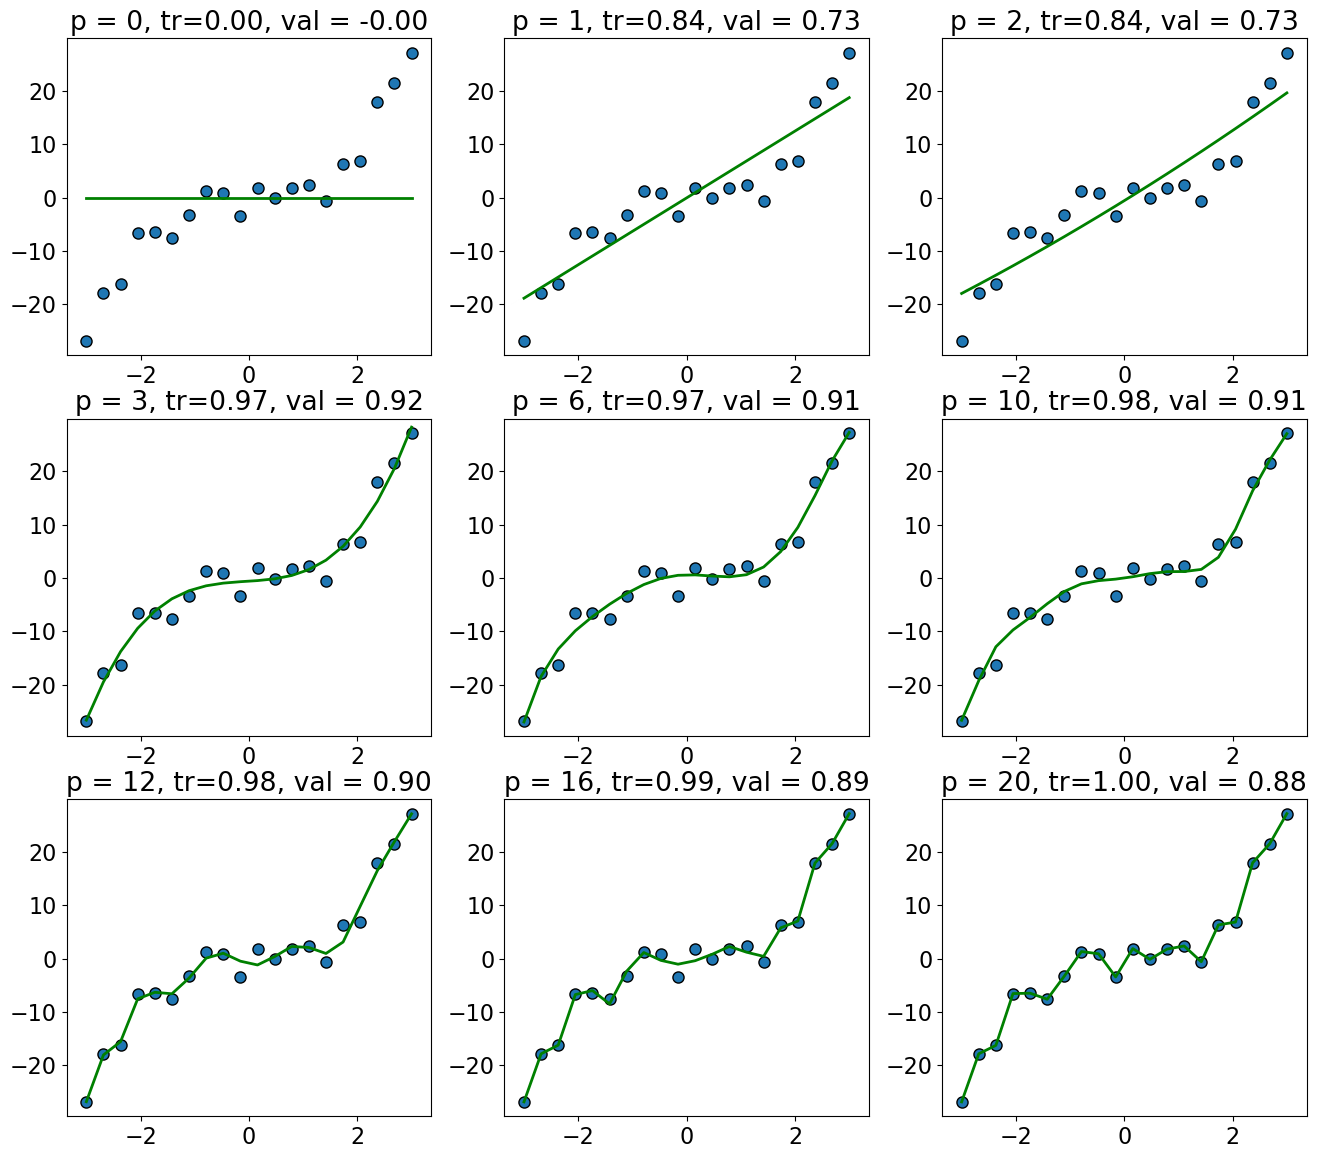

In [26]:
plot_train_valid_poly_deg(X_train, y_train, X_valid, y_valid)

- So there is a tradeoff between complexity of models and the validation score. 
- But what if we need complex models? 
- In supervised ML we try to find the mapping between $X$ and $y$, and usually the "true" mapping from $X$ to $y$ is complex.
    - Might need high-degree polynomial.
    - Might need to use many features, and don't know "relevant" ones.    

### Controlling model complexity

A few methods to control complexity: 
- Reduce the number of features (feature selection)
- Model averaging (coming up): average over multiple models to decrease variance (e.g., random forests) 
     
<!-- ![](img/random-forest-train-valid.png)     -->

<img src="img/random-forest-train-valid.png" width="400" height="400">

### Regularization intuition 
- Another popular method to control model complexity is by adding a penalty on the complexity of the model
    - Instead of minimizing just the Loss, we will minimize Loss + $\lambda $ Model complexity
    - Loss term measures how well the model fits the data.
    - Model complexity term, which is also referred to as **regularization term**, measures model complexity. 
    - A scalar $\lambda$ decides the overall impact of the regularization term. 

### How to quantify model complexity?
- Total number of features with non-zero weights 
    - L0 regularization: quantify model complexity as $\lVert w \rVert$, L0 norm of $w$. 
- As a function of weights: A feature weight with high absolute value is more complex than the feature weight with low absolute value. 
    - L2 regularization: quantify model complexity as $\lVert w \rVert_2^2$, square of the L2 norm of $w$. 
    - L1 regularization: quantify model complexity as $\lVert w \rVert_1$, L1 norm of $w$. 

<br><br>

### Terminology and notation

#### Reminder: L0, L1, and L2 norms

Given a vector $w$, 

- L0 norm $\lVert w \rVert \rightarrow$ the number of non-zero elements in $w$  
- L1 norm $\lVert w \rVert_1 = \lvert w_1 \rvert + \lvert w_2 \rvert + \dots + \lvert w_n \rvert$ 
- L2 norm $\lVert w \rVert_2 = (w_1^2 + w_2^2 + \dots + w_n^2)^{1/2}$ 
- Square of the L2 norm $\lVert w \rVert_2^2 = (w_1^2 + w_2^2 + \dots + w_n^2)$ 

In [27]:
from numpy import array
from numpy.linalg import norm

w = array([0, -2, 4])

l0 = norm(w, 0)  # number of non-zero values
l1 = norm(w, 1)  # sum of absolute values
l2 = norm(w, 2)  # square root of sum of the squared values
print("The l0 norm of %s is: %0.3f" % (w, l0))
print("The l1 norm of %s is: %0.3f" % (w, l1))
print("The l2 norm of %s is: %0.3f" % (w, l2))

The l0 norm of [ 0 -2  4] is: 2.000
The l1 norm of [ 0 -2  4] is: 6.000
The l2 norm of [ 0 -2  4] is: 4.472


In [28]:
# norms of a vector
from numpy import array
from numpy.linalg import norm

w = array([0, -2, 3, 0])
# l0 norm is the number of non-zero values in a vector
print("The l0 norm of %s is: %0.3f" % (w, norm(w, 0)))

# l1 norm is the sum of the absolute values in a vector.
print("The l1 norm of %s is: %0.3f" % (w, norm(w, 1)))

# l2 norm is square root of the sum of the squared values in a vector.
print("The l2 norm of %s is: %0.3f" % (w, norm(w, 2)))

The l0 norm of [ 0 -2  3  0] is: 2.000
The l1 norm of [ 0 -2  3  0] is: 5.000
The l2 norm of [ 0 -2  3  0] is: 3.606


- We can write least squares using this notation.
- It's the square of the L2 norm of the difference between predicted y's and true y's.  

$$ f(w) = \sum_{i=1}^{n}{(w^Tx_i - y_i)^2}$$

$$ f(w) = \lVert{Xw -y}\rVert_2^2$$

### (Optional) Vectorization

- We can organize all the training examples into a matrix $Z$ with one row per training example. 
- Then compute the predictions for the whole dataset succinctly as $Zw$ for the whole dataset: 
- We take each row of $Z$ and dot-product it with $w$. So the result is a vector of all our predictions.

$$Zw = \begin{bmatrix}w^Tz_0 \\ w^Tz_1 \\ \vdots \\ w^Tz_n\end{bmatrix} = \begin{bmatrix}z_0w \\ z_1w \\ \vdots \\ z_nw\end{bmatrix} = \begin{bmatrix} \hat{y_1} \\ \hat{y_2} \\ \vdots \\ \hat{y_n}\end{bmatrix} $$



- Sometimes, we refer to the transformed data (e.g., after applying polynomial transformations) as $Z$ (instead of $X$) and the weights associated with the transformed features as $v$ (instead of $w$). 
- So the least square loss function after applying polynomial transformations can be written as:  

$$f(w) = \lVert{Zv -y}\rVert_2^2$$

<br><br><br><br>

## Complexity penalties and L0 regularization 

### Model selection: complexity penalty 

- We want our model to fit the data well but we do not want an overly complex model. 
- How about penalizing complex models?  

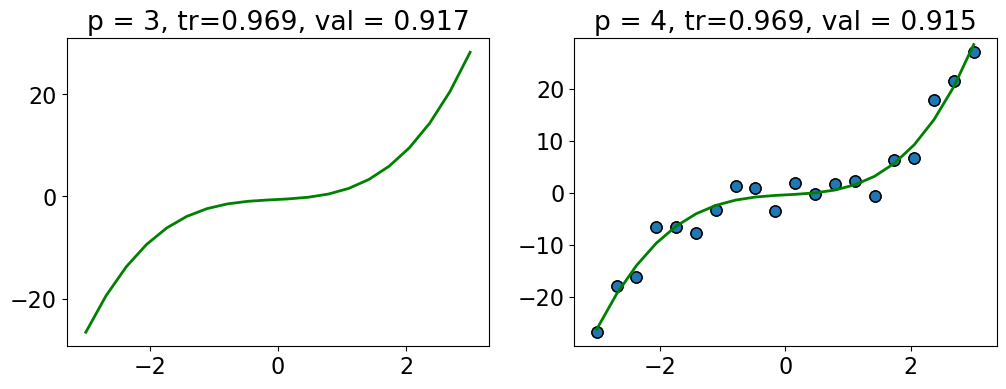

In [29]:
compare_poly_degrees(3, 4, X_train, y_train, X_valid, y_valid) # user-defined function in plotting_functions.py

- For example, here we are getting more or less the same scores with $p=3$ and $p=4$. 
- How about penalizing complex models a bit so that in such situation we would pick a simpler model?

### Complexity penalty

- Measure complexity in terms of the number of degrees of freedom or parameters in the model
- In case polynomial features, minimize the training error + the degree of 
polynomial. 
- Find $p$ that minimizes 

$$ score(p) = \lVert{Z_pv -y}\rVert^2 + p$$

- where
    - $p \rightarrow$ degree of polynomial in polynomial transformations
    - $Z_p \rightarrow$ transformed polynomial features
    - $v \rightarrow$ weights associated with $Z_p$

- If we use $p=3$, use loss + 3 as the total loss. 
- If we use $p=4$, use loss + 4 as the total loss. 
- If two $p$ have similar losses, this prefers smaller $p$.

### Optimizing this score

$$ score(p) = \lVert{Z_pv -y}\rVert_2^2 + p$$

- Form $Z_0$, solve for $v$ compute $ score(0) = \lVert{Z_0v -y}_2\rVert^2 + 0$
- Form $Z_1$, solve for $v$ compute $ score(1) = \lVert{Z_1v -y}\rVert^2 + 1$
- Form $Z_2$, solve for $v$ compute $ score(2) = \lVert{Z_2v -y}\rVert^2 + 2$
- Form $Z_3$, solve for $v$ compute $ score(3) = \lVert{Z_3v -y}\rVert^2 + 3$

Choose the degree with the lowest score. 
- We need to decrease the training error by at least 1 to increase degree by 1. 

### (Optional) Model selection

There are many scores usually with the form: 
$$ score(p) = \frac{1}{2}\lVert{Z_pv -y}\rVert^2 + \lambda k$$

$k\rightarrow \text{estimated parameters/degrees of freedom}$

$\lambda \rightarrow \text{penalization factor}$

- Pick the model with lowest score.
- The way we choose $\lambda$ gives us different statistical measures for model selection. 
- For example
    - AIC sets $\lambda = 1$ and penalizes the model complexity by the degree of freedom
    - BIC sets $\lambda = log(N)$, where $N$ is the number of examples. 
    - MSE does not penalize the model
    - Classification error does not penalize the model 

More on these measures [here](https://web.stanford.edu/~hastie/ElemStatLearn/printings/ESLII_print12.pdf). 
You'll learn more about this in DSCI 562. 

###  Remember the search and score methods for feature selection 

- Define a **scoring function** $f(S)$ that measures the quality of the set of features $S$. 
- Now **search** for the set of features $S$ with the best score.

- Example: Suppose you have three features: $A, B, C$
    - Compute **score** for $S = \{\}$
    - Compute **score** for $S = \{A\}$
    - Compute **score** for $S= \{B\}$
    - Compute **score** for $S = \{C\}$
    - Compute **score** for $S = \{A,B\}$    
    - Compute **score** for $S = \{A,C\}$
    - Compute **score** for $S = \{B,C\}$
    - Compute **score** for $S = \{A,B,C\}$    
- Return $S$ with the best score.  

### Scoring using complexity penalties

- Find $S$ and $W_s$ minimizing the squared error + the number of selected features 

$$ score(S) = \lVert{X_{S}w_S -y}\rVert_2^2 + size(S) $$


- $X_{S}$ is features $S$ of examples $X$. 
- Example
    - Suppose $S_1 = \{f_1, f_2, f_4\}$ $S_2 = \{f_1, f_2, f_4, f_5\}$ have similar error, it prefers $S_1$.
    - It prefers removing $f_5$ instead of keeping it with a small weight.
- Instead of $size(S)$, we usually write "$L0$ norm".

### $L0$ "norm"  and the number of features used

- In linear models, setting $w_j = 0$ is the same as removing the feature.
- Example: $$\hat{y_i} = w_1x_1 + w_2x_2 + w_3x_3 + w_4x_4$$
- $L0$ "norm" is the number of non-zero values.  
- If $w = \begin{bmatrix}0.8 \\ 0.0 \\ 0.03 \\0.1\end{bmatrix}$, $\lVert w\rVert_0 = 3$ and if $w = \begin{bmatrix}0.0 \\ 0.0 \\ 0.22 \\0.0\end{bmatrix}$, $\lVert w\rVert_0 = 1$


### Example 

Imagine the following two weight vectors which give the same error. 

$$w^1 = \begin{bmatrix}100 \\0\end{bmatrix}  w^2 = \begin{bmatrix}99.98 \\0.03\end{bmatrix}$$  

- Which one would be chosen by L0 regularization? 
<br><br><br><br><br><br><br><br>

- $\lVert w^1\rVert_0 = 1$ and $\lVert w^2\rVert_0 = 2$. So it will pick $w^1$.

### Scoring using $L0$ "norm" 

- Most common "scores" have the form.

$$f(w) = \lVert{Xw -y}\rVert^2_2 + \lambda \lVert w\rVert_0$$

- $\lVert{Xw -y}\rVert^2_2 \rightarrow$ square of the L2 norm $Xw -y$
- $\lambda \rightarrow$ penalty parameter
- $\lVert w\rVert_0 \rightarrow$  L0 norm of $w$      
    - The number of non-zero values in $w$.                

- To increase the degrees of freedom by one, need to decrease the error by $\lambda$. 
- Prefer smaller degrees of freedom if errors are similar. 
- Can't optimize because the function is discontinuous in $\lVert w\rVert_0$
    - Search over possible models 

<br><br><br><br>

## L2 regularization

### Idea of regularization: Pick the line/hyperplane with smaller slope 

- Assuming red and green models have the same training error and if you are forced to choose one of them, which one would you pick?
    - **Pick the solid green line because its slope is smaller.**
    - Small change in $x_i$ has a smaller change in prediction $y_i$
    - Since $w$ is less sensitive to the training data, it's likely to generalize better.  
![](img/regularization.png)
<!-- <img src='img/green_or_red.png' width="600" height="600" /> -->


- Standard regularization strategy is L2 regularization
    - We incorporate L2 penalty in the loss function $f(w)$: 
$$f(w) = \sum_i^n(w^Tx_i - y_i)^2 + \lambda\sum_j^d w_j^2 \text{ or }$$ 
$$f(w) = \lVert Xw - y\rVert_2^2 + \lambda \lVert w\rVert_2^2$$

- $\lVert Xw - y\rVert_2^2 \rightarrow$ square of the $L2$ norm of $Xw -y$
- $\lambda \rightarrow$ regularization strength    
- $\lVert w\rVert_2^2 \rightarrow$  square of the L2 norm of $w$      
    - sum of the squared weight values.              

### L2 regularization 

$$f(w) = \lVert Xw - y\rVert_2^2 + \lambda\lVert w\rVert_2^2$$

- Objective balances getting low error vs. having small slopes $w_j$
- In terms of fundamental trade-off:
    - You can increase the training error. 
    - Nearly-always reduces overfitting and the validation error.    

### Regularization demo

- Let's generate some synthetic data with N = 20 points. 

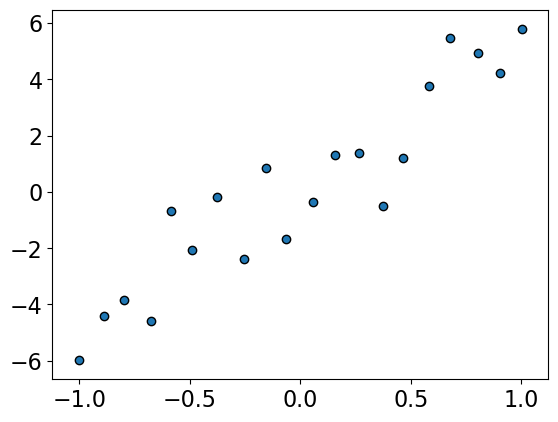

In [30]:

np.random.seed(4)
N = 20
X = np.linspace(-1, 1, N) + npr.randn(N) * 0.01
X = X[:, None]
y = npr.randn(N, 1) + X * 5

mglearn.discrete_scatter(X, y, s=6, labels=["training data"]);


Let's fit with degree $N-1$ polynomial

1.0

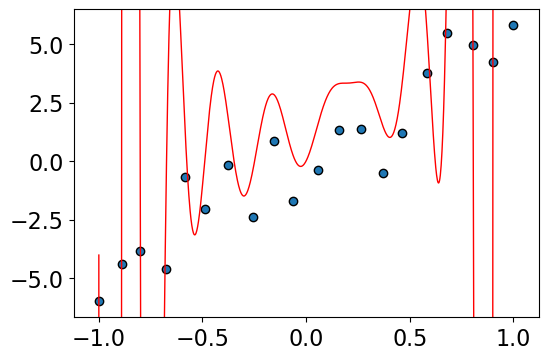

In [31]:
pf = PolynomialFeatures(19)
Z = pf.fit_transform(X)

lr = LinearRegression()
lr.fit(Z, y)
w_lr_19 = lr.coef_.flatten()
grid = np.linspace(min(X), max(X), 1000)
grid_poly_19 = pf.fit_transform(grid)
plt.figure(figsize=(6,4))
mglearn.discrete_scatter(X, y, s=6, labels=["training data"])
plt.plot(grid, grid_poly_19 @ w_lr_19, c="red", linewidth=1);
lr.score(Z, y)

- Problem: this results are crazy (overfitting). 
- Bigger values of weights means the model is very sensitive to the training data. 

In [32]:
pd.DataFrame(w_lr_19, index=pf.get_feature_names_out(), columns=["weights"]).tail()

,weights
x0^15,-5.150150e+07
x0^16,-5.316861e+06
x0^17,3.466582e+07
x0^18,1.482311e+06
x0^19,-9.517721e+06


In [33]:
print(max(abs(w_lr_19)))

51501499.24478904


### Solution 1: Use a lower degree polynomial

0.8717193637247818

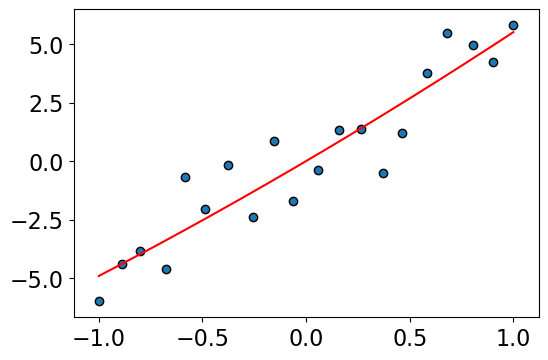

In [34]:
pf = PolynomialFeatures(2)
Z = pf.fit_transform(X)
lr = LinearRegression()
lr.fit(Z, y)
w_lr_2 = lr.coef_.flatten()
grid_poly_2 = pf.fit_transform(grid)
plt.figure(figsize=(6,4))
mglearn.discrete_scatter(X, y, s=6, labels=["training data"])
plt.plot(grid, grid_poly_2 @ w_lr_2, c="red");
lr.score(Z, y)

- The lower degree polynomial looks good.
- But if the true relationship really was complicated? Then if we restricted the degree of the polynomial, we'd miss out on it.


### Solution 2: Use regularization 

- The idea of regularization is to "regularize" weights so that they are small and so less sensitive to the data. 

0.9135817441429818

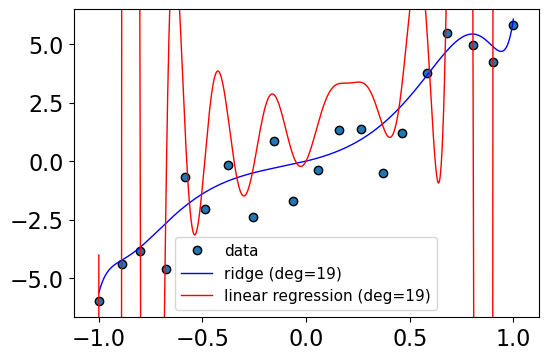

In [35]:
pf = PolynomialFeatures(19)
Z = pf.fit_transform(X)

r = Ridge(alpha=0.01)  # Regularized linear regression
r.fit(Z, y)
w_ridge_19 = r.coef_.flatten()
plt.figure(figsize=(6,4))
mglearn.discrete_scatter(X, y, s=6, labels=["training data"])
grid_poly_ridge = pf.fit_transform(grid)
plt.plot(grid, grid_poly_ridge @ w_ridge_19, c="blue", linewidth=1);
plt.plot(grid, grid_poly_19 @ w_lr_19, c="red", linewidth=1);
plt.legend(["data", 'ridge (deg=19)', 'linear regression (deg=19)'], loc="best", fontsize=11);
r.score(Z, y)

In [36]:
pd.DataFrame(w_ridge_19, index=pf.get_feature_names_out(), columns=["weights"]).tail()

,weights
x0^15,0.780600
x0^16,1.170325
x0^17,2.655623
x0^18,1.800171
x0^19,4.240822


In [37]:
print(max(abs(w_ridge_19)))

8.010363113222288


- Regularization helped! Even though we used a degree $N-1$ polynomial, we didn't end up with a crazy model.
- We are keeping all the complex features but assigning small weights to higher degree polynomial. 
- We can add regularization to many models, not just least squares with a polynomial basis.

### Why are small weights better?
- Somewhat non-intuitive. 
- Suppose $x_1$ and $x_2$ are nearby each other. 
- We might expect that they have similar $\hat{y}$. 
- If we change feature1 value by a small amount $\epsilon$ in $x_2$, leaving everything else the same, we might think that the prediction would be the same.
- But if we have bigger weights small change in $x_2$ has a large effect on the prediction. 

In [38]:
x_1 = np.array([1, 1, 0, 1, 1, 0])
x_2 = np.array([0.8, 1, 0, 1, 1, 0])
weights = np.array([100, 0.1, 1, 0.22, 4, 3])

print("x_1 prediction: ", x_1.dot(weights))
print("x_2 prediction: ", x_2.dot(weights))

x_1 prediction:  104.32
x_2 prediction:  84.32


- In linear models, the rate of change of the prediction function is proportional to the individual weights. 
- So if we want the function to change slowly, we want to ensure that the weights stay small.
- The idea is to avoid putting all our energy into one features, which might give us over-confident predictions and lead to overfitting. 

### Have we seen L2 regularization before? 

- [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html): Linear Regression with L2 regularization 

> class sklearn.linear_model.Ridge(alpha=1.0, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, tol=0.001, solver='auto', random_state=None)

> Linear least squares with l2 regularization. Minimizes the objective function: ||y - Xw||^2_2 + alpha * ||w||^2_2
This model solves a regression model where the loss function is the linear least squares function and regularization is given by the l2-norm. Also known as Ridge Regression or Tikhonov regularization.

- Uses the hyperparameter $\alpha$ for regularization strength instead of $\lambda$; larger value of $\alpha$ means more regularization.
$$f(w) = \lVert Xw - y\rVert_2^2 + \alpha \lVert w\rVert_2^2$$
 

- [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html): Logistic Regression with L2 regularization 

> class sklearn.linear_model.LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)

- `C`: default=1.0
Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization. 

<br><br><br><br>

## Summary: What did we learn today?

- Loss functions (high level)
    - OLS vs absolute loss
    - 0/1 loss
    - Exponential loss
    - Hinge loss
    - Logistic loss
- Adding complexity penalties to the loss function
    - L0 penalty 
    - Introduction to L2 regularization 
- Coming up
    - More on L2 regularization
    - L1 regularization 

<br><br><br><br>

## ❓❓ Questions for you

### Exercise 5.1 L0 and L2-regularization

**Select all the statements below which are True.**

- (A) In the equation below of L0-regularization, smaller value for $\lVert w\rVert_0$ means we discard most of the features. 
$$ f(w) = \lVert{Xw -y}\rVert^2 + \lambda \lVert w\rVert_0$$
- (B) In the above equation, larger $\lambda$ means aggressively changing many weights to zero. 

**V's answers: A, B,**

### Exercise 5.2 

Imagine that you fit `Ridge` twice with different values of $\alpha$, $\alpha = 0$ and $\alpha=10$. You are given the weights learned from two different models below. Without knowing which weights came from which model, you can guess that $w^1$ probably corresponds to $\alpha = 10$ and $w^2$ probably corresponds to $\alpha = 0$.

$$w^1 = \begin{bmatrix} 32.43\\23.14\\16.4\end{bmatrix} \text{ and }w^2 = \begin{bmatrix} 2.03\\1.2\\0.4\end{bmatrix}$$ 

**V's answers: False. Bigger alpha means the weights should be smaller.**

![](img/eva-talksoon.png)